In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Генерація даних про користувачів стрімінгового сервісу
np.random.seed(42)
n_users = 500

data = {
    'WatchTime': np.random.randint(1, 50, n_users),
    'ContentDiversity': np.random.randint(1, 100, n_users),
    'SessionFrequency': np.random.randint(1, 30, n_users)
}

df = pd.DataFrame(data)
print("Перші 5 користувачів:")
print(df.head())
print("\nСтатистика:")
print(df.describe())


Перші 5 користувачів:
   WatchTime  ContentDiversity  SessionFrequency
0         39                23                23
1         29                10                 9
2         15                69                23
3         43                34                 3
4          8                52                19

Статистика:
        WatchTime  ContentDiversity  SessionFrequency
count  500.000000        500.000000         500.00000
mean    25.678000         49.370000          14.48000
std     14.127898         29.195854           8.50307
min      1.000000          1.000000           1.00000
25%     14.000000         24.000000           7.00000
50%     26.000000         50.000000          14.00000
75%     37.000000         75.000000          22.00000
max     49.000000         99.000000          29.00000


In [3]:
# Стандартизація даних (критично для DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


In [4]:
# Пошук оптимальних параметрів eps та min_samples
# Метод 1: Перебір параметрів з оцінкою Silhouette Score

eps_range = np.arange(0.3, 2.0, 0.1)
min_samples_range = range(3, 15)

best_score = -1
best_params = {}
results = []

print("Пошук оптимальних параметрів:")
print("eps\tmin_samples\tClusters\tNoise\tSilhouette")

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Silhouette Score (тільки якщо є хоча б 2 кластери)
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            score = silhouette_score(X_scaled, labels)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': score
            })

            print(f"{eps:.1f}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t{score:.3f}")

            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"\nОптимальні параметри: eps={best_params['eps']:.1f}, min_samples={best_params['min_samples']}")
print(f"Найкращий Silhouette Score: {best_score:.3f}")


Пошук оптимальних параметрів:
eps	min_samples	Clusters	Noise	Silhouette
0.3	3		53		233	-0.126
0.3	4		28		361	-0.337
0.3	5		6		464	-0.414
0.4	3		20		44	-0.248
0.4	4		18		86	-0.138
0.4	5		20		171	-0.059
0.4	6		28		242	-0.152
0.4	7		16		365	-0.298
0.4	8		6		449	-0.342
0.5	4		2		13	-0.013
0.5	5		4		30	-0.142
0.5	6		2		52	-0.045
0.5	7		4		79	-0.126
0.5	8		6		125	-0.068
0.5	9		11		178	-0.050
0.5	10		11		254	-0.140
0.5	11		11		323	-0.206
0.5	12		4		435	-0.248
0.5	13		2		474	-0.258
0.6	12		4		88	0.047
0.6	13		7		127	-0.085
0.6	14		7		182	-0.068

Оптимальні параметри: eps=0.6, min_samples=12
Найкращий Silhouette Score: 0.047


In [5]:
# Кластеризація з оптимальними параметрами
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df['Cluster'] = dbscan.fit_predict(X_scaled)

# Статистика
n_clusters = len(set(df['Cluster'])) - (1 if -1 in df['Cluster'] else 0)
n_noise = list(df['Cluster']).count(-1)
n_core = len(dbscan.core_sample_indices_)

print(f"\nРезультати кластеризації:")
print(f"  Знайдено кластерів: {n_clusters}")
print(f"  Noise точок: {n_noise} ({n_noise/len(df)*100:.1f}%)")
print(f"  Core points: {n_core} ({n_core/len(df)*100:.1f}%)")



Результати кластеризації:
  Знайдено кластерів: 5
  Noise точок: 88 (17.6%)
  Core points: 164 (32.8%)


In [6]:
# Аналіз кластерів (без noise)
valid_clusters = df[df['Cluster'] != -1]

if len(valid_clusters) > 0:
    print("\nАналіз кластерів (без noise):")
    cluster_summary = valid_clusters.groupby('Cluster').agg({
        'WatchTime': ['mean', 'std', 'count'],
        'ContentDiversity': ['mean', 'std'],
        'SessionFrequency': ['mean', 'std']
    }).round(2)
    print(cluster_summary)

print("\nРозподіл точок по кластерах:")
print(df['Cluster'].value_counts().sort_index())



Аналіз кластерів (без noise):
        WatchTime              ContentDiversity        SessionFrequency      
             mean    std count             mean    std             mean   std
Cluster                                                                      
0           35.95   7.68   128            23.95  13.88            13.12  7.15
1           23.33  12.19   230            61.89  21.67            14.63  8.20
2            6.76   4.08    33            85.58   8.42             7.91  4.27
3           12.24   5.85    21            20.86   9.94            23.67  2.08

Розподіл точок по кластерах:
Cluster
-1     88
 0    128
 1    230
 2     33
 3     21
Name: count, dtype: int64


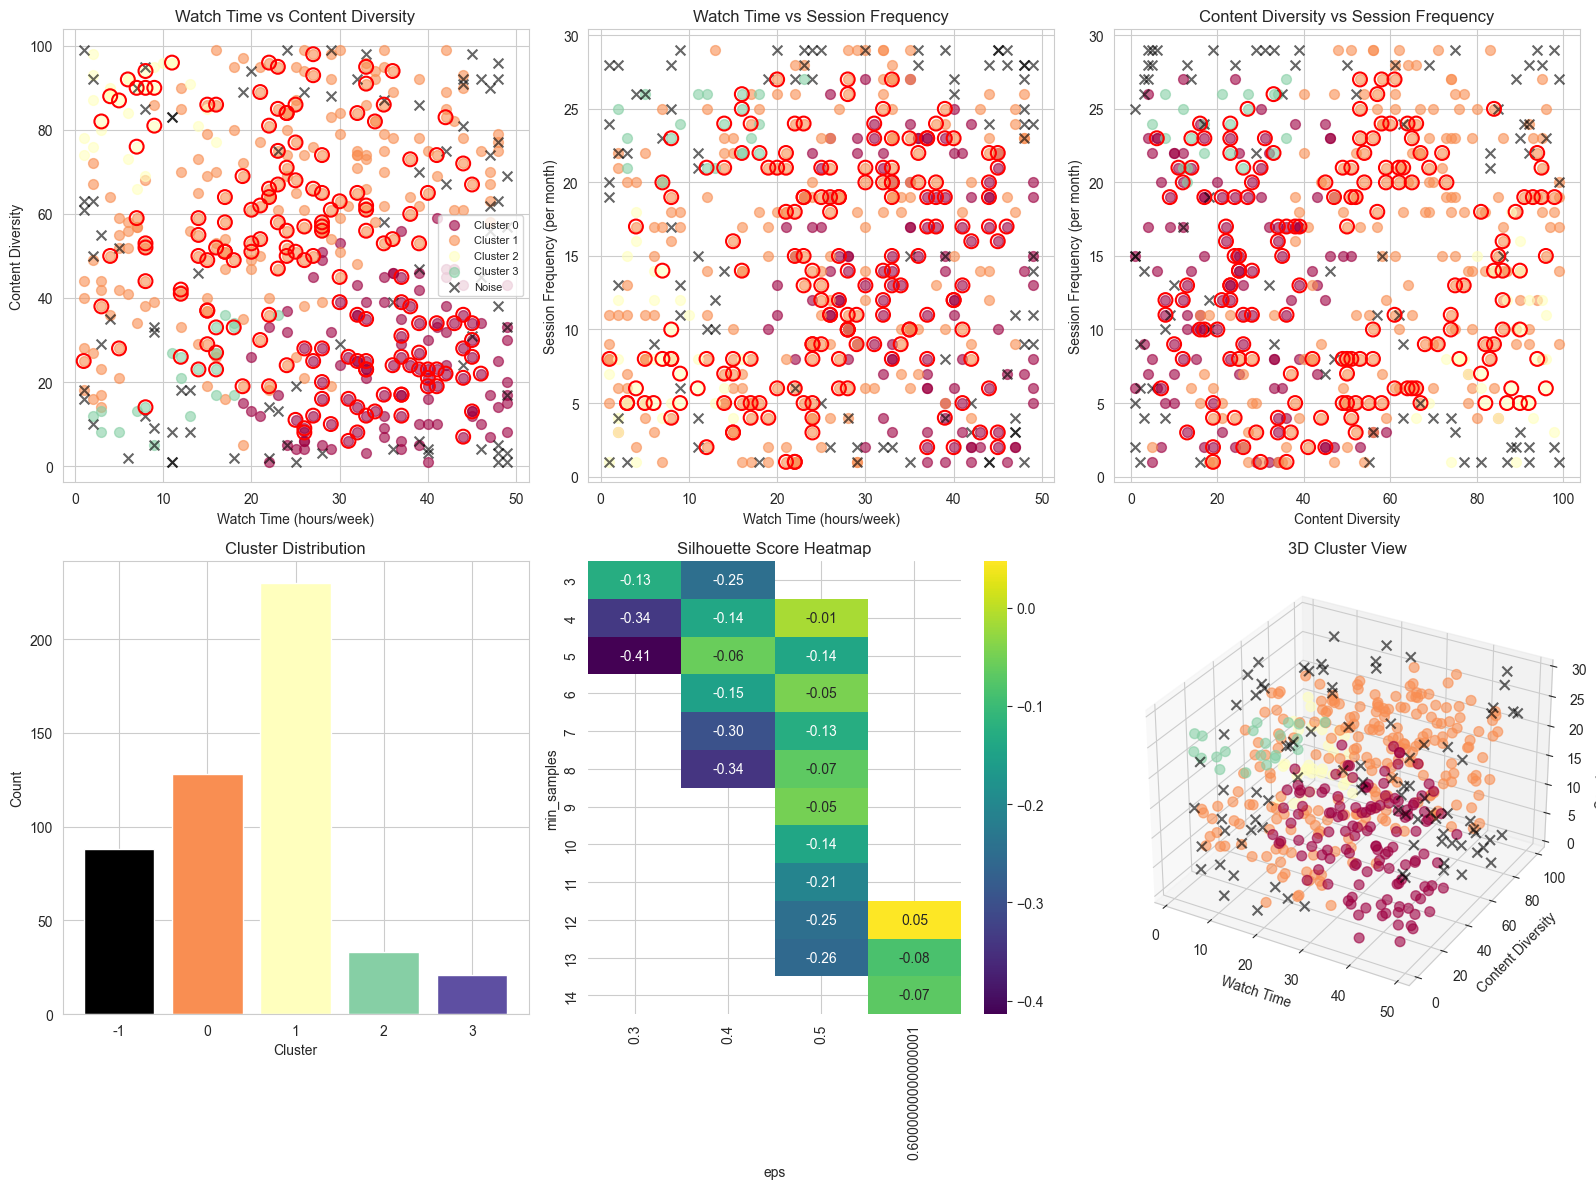

In [7]:
# Візуалізація
fig = plt.figure(figsize=(16, 12))

# Кольори для кластерів
unique_labels = set(df['Cluster'])
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# 1. WatchTime vs ContentDiversity
ax1 = plt.subplot(2, 3, 1)
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
        marker = 'x'
    else:
        marker = 'o'

    class_member_mask = (df['Cluster'] == k)
    xy = df[class_member_mask]
    ax1.scatter(xy['WatchTime'], xy['ContentDiversity'],
                c=[col], marker=marker, s=50, alpha=0.6,
                label=f'Cluster {k}' if k != -1 else 'Noise')

# Виділення core points
core_samples_mask = np.zeros(len(df), dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
ax1.scatter(df[core_samples_mask]['WatchTime'],
            df[core_samples_mask]['ContentDiversity'],
            s=100, facecolors='none', edgecolors='red', linewidths=1.5)

ax1.set_xlabel('Watch Time (hours/week)')
ax1.set_ylabel('Content Diversity')
ax1.set_title('Watch Time vs Content Diversity')
ax1.legend(loc='best', fontsize=8)

# 2. WatchTime vs SessionFrequency
ax2 = plt.subplot(2, 3, 2)
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
        marker = 'x'
    else:
        marker = 'o'

    class_member_mask = (df['Cluster'] == k)
    xy = df[class_member_mask]
    ax2.scatter(xy['WatchTime'], xy['SessionFrequency'],
                c=[col], marker=marker, s=50, alpha=0.6)

ax2.scatter(df[core_samples_mask]['WatchTime'],
            df[core_samples_mask]['SessionFrequency'],
            s=100, facecolors='none', edgecolors='red', linewidths=1.5)

ax2.set_xlabel('Watch Time (hours/week)')
ax2.set_ylabel('Session Frequency (per month)')
ax2.set_title('Watch Time vs Session Frequency')

# 3. ContentDiversity vs SessionFrequency
ax3 = plt.subplot(2, 3, 3)
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
        marker = 'x'
    else:
        marker = 'o'

    class_member_mask = (df['Cluster'] == k)
    xy = df[class_member_mask]
    ax3.scatter(xy['ContentDiversity'], xy['SessionFrequency'],
                c=[col], marker=marker, s=50, alpha=0.6)

ax3.scatter(df[core_samples_mask]['ContentDiversity'],
            df[core_samples_mask]['SessionFrequency'],
            s=100, facecolors='none', edgecolors='red', linewidths=1.5)

ax3.set_xlabel('Content Diversity')
ax3.set_ylabel('Session Frequency (per month)')
ax3.set_title('Content Diversity vs Session Frequency')

# 4. Розподіл кластерів
ax4 = plt.subplot(2, 3, 4)
cluster_counts = df['Cluster'].value_counts().sort_index()
bars = ax4.bar(range(len(cluster_counts)), cluster_counts.values,
               color=['black' if x == -1 else colors[i] for i, x in enumerate(cluster_counts.index)])
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Count')
ax4.set_title('Cluster Distribution')
ax4.set_xticks(range(len(cluster_counts)))
ax4.set_xticklabels([f'{x}' for x in cluster_counts.index])

# 5. Heatmap параметрів
ax5 = plt.subplot(2, 3, 5)
if results:
    results_df = pd.DataFrame(results)
    pivot_table = results_df.pivot_table(values='silhouette',
                                          index='min_samples',
                                          columns='eps',
                                          aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='viridis', ax=ax5)
    ax5.set_title('Silhouette Score Heatmap')
    ax5.set_xlabel('eps')
    ax5.set_ylabel('min_samples')

# 6. 3D візуалізація
ax6 = plt.subplot(2, 3, 6, projection='3d')
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
        marker = 'x'
    else:
        marker = 'o'

    class_member_mask = (df['Cluster'] == k)
    xy = df[class_member_mask]
    ax6.scatter(xy['WatchTime'], xy['ContentDiversity'], xy['SessionFrequency'],
                c=[col], marker=marker, s=50, alpha=0.6)

ax6.set_xlabel('Watch Time')
ax6.set_ylabel('Content Diversity')
ax6.set_zlabel('Session Frequency')
ax6.set_title('3D Cluster View')

plt.tight_layout()
plt.show()


In [8]:
# Інтерпретація кластерів
print("\nІнтерпретація кластерів:")

for cluster in sorted(set(df['Cluster'])):
    cluster_data = df[df['Cluster'] == cluster]

    if cluster == -1:
        print(f"\nNoise (Cluster -1):")
        print(f"  Users: {len(cluster_data)}")
        print(f"  Це аномальні користувачі, які не вписуються в жоден кластер")
        continue

    avg_watch = cluster_data['WatchTime'].mean()
    avg_diversity = cluster_data['ContentDiversity'].mean()
    avg_frequency = cluster_data['SessionFrequency'].mean()

    # Визначення типу користувача
    if avg_watch > 30 and avg_frequency > 20:
        cluster_type = "Hardcore Fans"
    elif avg_watch > 30:
        cluster_type = "Binge Watchers"
    elif avg_frequency > 20:
        cluster_type = "Frequent Users"
    elif avg_diversity > 70:
        cluster_type = "Content Explorers"
    elif avg_watch < 15 and avg_frequency < 10:
        cluster_type = "Casual Viewers"
    else:
        cluster_type = "Regular Users"

    print(f"\nCluster {cluster}: {cluster_type}")
    print(f"  Users: {len(cluster_data)}")
    print(f"  Watch Time: {avg_watch:.1f} hours/week")
    print(f"  Content Diversity: {avg_diversity:.1f}/100")
    print(f"  Session Frequency: {avg_frequency:.1f} times/month")



Інтерпретація кластерів:

Noise (Cluster -1):
  Users: 88
  Це аномальні користувачі, які не вписуються в жоден кластер

Cluster 0: Binge Watchers
  Users: 128
  Watch Time: 36.0 hours/week
  Content Diversity: 23.9/100
  Session Frequency: 13.1 times/month

Cluster 1: Regular Users
  Users: 230
  Watch Time: 23.3 hours/week
  Content Diversity: 61.9/100
  Session Frequency: 14.6 times/month

Cluster 2: Content Explorers
  Users: 33
  Watch Time: 6.8 hours/week
  Content Diversity: 85.6/100
  Session Frequency: 7.9 times/month

Cluster 3: Frequent Users
  Users: 21
  Watch Time: 12.2 hours/week
  Content Diversity: 20.9/100
  Session Frequency: 23.7 times/month


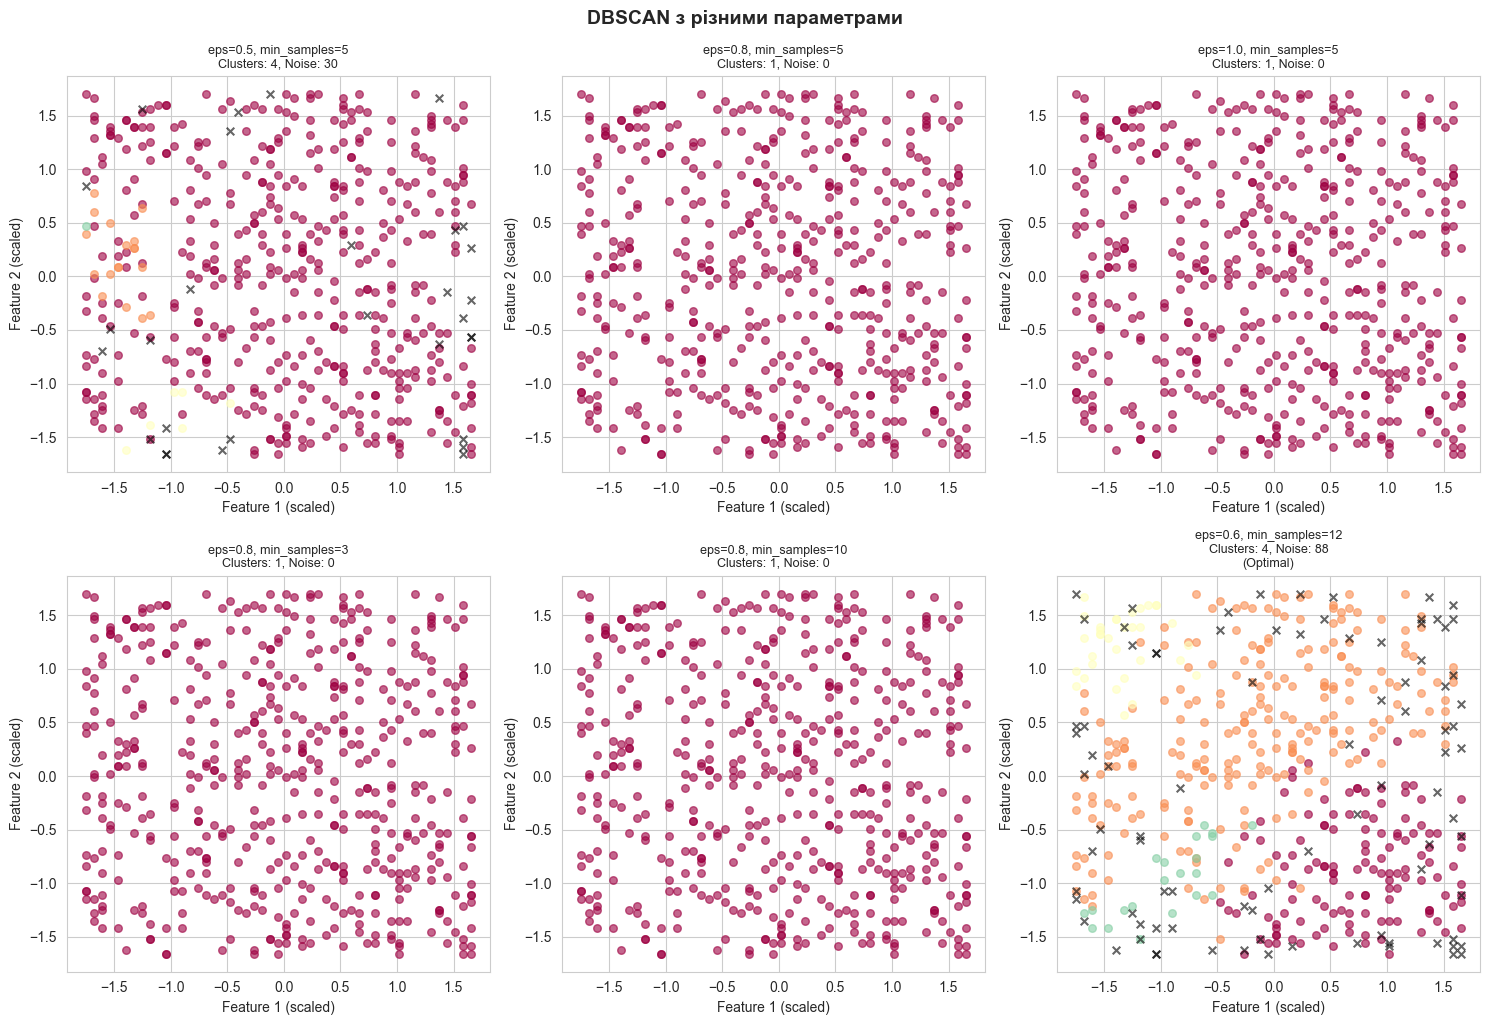

In [9]:
# Порівняння з різними параметрами (опціонально)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

test_params = [
    (0.5, 5),
    (0.8, 5),
    (1.0, 5),
    (0.8, 3),
    (0.8, 10),
    (best_params['eps'], best_params['min_samples'])
]

for idx, (eps, min_samples) in enumerate(test_params):
    ax = axes[idx]

    dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
    labels_test = dbscan_test.fit_predict(X_scaled)

    n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise_test = list(labels_test).count(-1)

    unique_labels_test = set(labels_test)
    colors_test = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_test)))

    for k, col in zip(unique_labels_test, colors_test):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'

        class_member_mask = (labels_test == k)
        xy = X_scaled[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=30, alpha=0.6)

    title = f'eps={eps:.1f}, min_samples={min_samples}\n'
    title += f'Clusters: {n_clusters_test}, Noise: {n_noise_test}'
    if idx == 5:
        title += '\n(Optimal)'

    ax.set_title(title, fontsize=9)
    ax.set_xlabel('Feature 1 (scaled)')
    ax.set_ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.suptitle('DBSCAN з різними параметрами', y=1.02, fontsize=14, fontweight='bold')
plt.show()